# Clustered Approach to Ocean Mixing Parameterization

This notebook demonstrates the new class-based architecture for clustered ocean mixing parameterization. It implements both input-based clustering and shape function (output) clustering approaches.

## Key Features

1. **Modular Design**: Easy to swap clustering algorithms, networks, and training parameters
2. **Multiple Approaches**: Supports both input-based and output-based clustering
3. **Visualization Tools**: Comprehensive tools for visualizing clusters, performance, and shape functions
4. **Clean API**: Consistent interface for training, prediction, and evaluation

In [1]:
# Import standard libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import seaborn as sns
import copy
import xarray as xr
from datetime import datetime
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

# Setup notebook environment
today = datetime.today()
np.random.seed(100)
torch.manual_seed(100)

# Fix paths
cwd = os.getcwd()
parent_dir = os.path.dirname(cwd)
os.chdir(parent_dir)
cwd = parent_dir
print("Current working directory:", os.getcwd())

# Import custom modules
import lib.func_file as ff
from lib.ocean_models import OceanMixingNN, OceanMixingResidualNN
from lib.clustered_models import (
    InputClusteredModel, 
    OutputClusteredModel,
    ClusterModelVisualizer
)

# Set up directories
cwd_data = cwd + '/Data/'
cwd_output = cwd + '/output/'
os.makedirs(cwd_output, exist_ok=True)

# Set device for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Current working directory: /home/jovyan/dhruv/LEAPCourse-Climate-Pred-Challenges/Project-StarterCodes/Project2-Parameterization
Using device: cuda


## 1. Load and Preprocess Data

Following the same data loading approach from the original paper.

In [2]:
# Load GOTM training data produced by Sane et al. 2023
store = 'https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/sf_training_data.zarr'
d = xr.open_dataset(store, engine='zarr', chunks={})

# Coriolis parameter calculation
def corio(lat):
    return 2*(2*np.pi/(24*60*60)) * np.sin(lat*(np.pi/180))

# Extract variables
l0 = corio(d['l'][:])
b00 = d['b0'][:]
ustar0 = d['ustar'][:]
h0 = d['h'][:]
lat0 = d['lat'][:]
heat0 = d['heat'][:]
tx0 = d['tx'][:]
tx0 = np.round(tx0, 2)
SF0 = d['SF'][:]

In [3]:
# Apply the same filtering criteria as in Sane et al. (2023)
ind101 = np.where(np.abs(heat0) < 601)[0]
ind1 = ind101
ind2 = np.where(tx0 < 1.2)[0]
ind3 = np.where(h0 > 29)[0]
ind4 = np.where(h0 < 301)[0]

# Combine all filters
ind5 = np.intersect1d(ind1, ind2)
ind6 = np.intersect1d(ind3, ind5)
ind7 = np.intersect1d(ind4, ind6)

# Prepare data for model training
mm1 = 0; mm2 = 16  # 16 levels (level 1 at bottom, level 16 at top)
data_load_main = np.zeros([len(h0[ind7]), 4 + mm2 - mm1])
data_load_main[:, 0] = l0[ind7]     # Coriolis parameter
data_load_main[:, 1] = b00[ind7]    # Surface buoyancy flux
data_load_main[:, 2] = ustar0[ind7] # Surface friction velocity
data_load_main[:, 3] = h0[ind7]     # Boundary layer depth
data_load_main[:, 4:(mm2 - mm1 + 4)] = SF0[ind7, mm1:mm2] # Shape functions

# Store additional forcing variables for reference
data_forc = np.zeros([len(ind7), 3])
data_forc[:, 0] = lat0[ind7]  # Latitude
data_forc[:, 1] = heat0[ind7] # Heat flux
data_forc[:, 2] = tx0[ind7]   # Wind stress

# Create a copy of the data for processing
data_load3 = copy.deepcopy(data_load_main)

# Preprocess data using the same function as in the original code
print('Preprocessing data...')
data, x, y, stats, k_mean, k_std = ff.preprocess_train_data(data_load3)
print('Done preprocessing')

Preprocessing data...
Done preprocessing


In [4]:
# Load validation data
url = "https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/data_testing_4_paper.txt"
df = pd.read_csv(url, delim_whitespace=True, header=None)
valid_data = df.iloc[:, 3:].values

# Apply same filtering criteria
ind3 = np.where(valid_data[:, 3] > 29)[0]
ind4 = np.where(valid_data[:, 3] < 301)[0]
ind = np.intersect1d(ind3, ind4)

# Extract and normalize validation features
valid_x_np = valid_data[ind, 0:4]
valid_x_np[:, 0] = (valid_x_np[:, 0] - stats[0]) / stats[1]  # Normalize Coriolis
valid_x_np[:, 1] = (valid_x_np[:, 1] - stats[2]) / stats[3]  # Normalize buoyancy flux
valid_x_np[:, 2] = (valid_x_np[:, 2] - stats[4]) / stats[5]  # Normalize friction velocity
valid_x_np[:, 3] = (valid_x_np[:, 3] - stats[6]) / stats[7]  # Normalize layer depth

# Extract and normalize validation targets
valid_y_np = valid_data[ind, 5:]
for i in range(len(valid_y_np)):
    valid_y_np[i, :] = np.log(valid_y_np[i, :] / np.max(valid_y_np[i, :]))
for i in range(16):
    valid_y_np[:, i] = (valid_y_np[:, i] - k_mean[i]) / k_std[i]

# Convert to PyTorch tensors
valid_x = torch.FloatTensor(valid_x_np).to(device)
valid_y = torch.FloatTensor(valid_y_np).to(device)

print(f"Training data shape: {x.shape}, {y.shape}")
print(f"Validation data shape: {valid_x.shape}, {valid_y.shape}")

Training data shape: (917858, 4), (917858, 16)
Validation data shape: torch.Size([89899, 4]), torch.Size([89899, 16])


## 2. Train the Baseline Model

We'll first train a single baseline model on all data.

In [5]:
# Define model parameters
model_params = {
    'in_nodes': 4,      # 4 input features
    'hidden_nodes': 32, # 32 nodes per hidden layer
    'out_nodes': 16,    # 16 output points
    'dropout_rate': 0.25  # Dropout for regularization
}

# Create the baseline model
baseline_model = OceanMixingNN(**model_params).to(device)

# Create a simplified BaseClusteredModel for the baseline (just for consistent API)
class BaselineModel(InputClusteredModel):
    def __init__(self, model_class, model_params):
        super().__init__(model_class, model_params, n_clusters=1)
        
    def fit(self, X, y, valid_X=None, valid_y=None, stats=None):
        # Convert to tensors if needed
        if isinstance(X, np.ndarray):
            X_tensor = torch.FloatTensor(X).to(self.device)
        else:
            X_tensor = X.to(self.device)
            
        if isinstance(y, np.ndarray):
            y_tensor = torch.FloatTensor(y).to(self.device)
        else:
            y_tensor = y.to(self.device)
        
        # Store stats
        self.stats = stats
        
        # Initialize model
        model = self.model_class(**self.model_params).to(self.device)
        
        # Train a single model on all data
        print("Training baseline model on all data...")
        trained_model, losses = self._train_model(
            model=model,
            X=X_tensor,
            y=y_tensor,
            valid_X=valid_X,
            valid_y=valid_y,
            stats=stats
        )
        
        # Store in cluster_models[0] for consistent API
        self.cluster_models[0] = {
            'model': trained_model,
            'losses': losses
        }
        
        return self
    
    def predict(self, X):
        # Convert to tensor if needed
        if isinstance(X, np.ndarray):
            X_tensor = torch.FloatTensor(X).to(self.device)
        else:
            X_tensor = X.to(self.device)
        
        # Use the single model for all predictions
        model = self.cluster_models[0]['model']
        with torch.no_grad():
            preds = model(X_tensor)
        
        # Return predictions and dummy cluster assignments (all 0)
        dummy_clusters = np.zeros(len(X), dtype=int)
        return preds, dummy_clusters

# Create and train the baseline model
baseline = BaselineModel(OceanMixingNN, model_params)
baseline.fit(x, y, valid_x, valid_y, {'k_mean': k_mean, 'k_std': k_std})

Training baseline model on all data...


Training:  68%|██████▊   | 2048/3000 [01:32<00:43, 22.07it/s, train_loss=0.0349, valid_loss=0.0437, patience=49]


Early stopping at epoch 2048


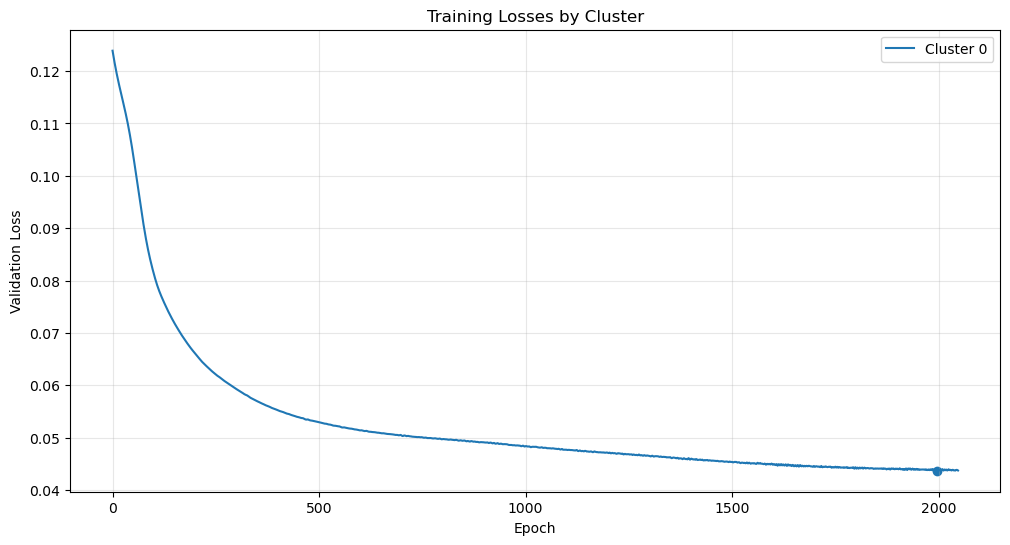

In [6]:
# Plot training losses for the baseline model
visualizer = ClusterModelVisualizer()
visualizer.plot_losses(baseline)

In [7]:
# Evaluate baseline model
baseline_metrics = baseline.evaluate(
    valid_x, valid_y, {'k_mean': k_mean, 'k_std': k_std}
)

print(f"Baseline overall MAE: {baseline_metrics['mae']:.6f}")
print("\nBaseline node-wise MAE:")
for i, mae in enumerate(baseline_metrics['node_mae']):
    print(f"Layer {i+1}: {mae:.6f}")

Baseline overall MAE: 0.043685

Baseline node-wise MAE:
Layer 1: 0.007453
Layer 2: 0.012374
Layer 3: 0.058822
Layer 4: 0.086458
Layer 5: 0.100676
Layer 6: 0.082882
Layer 7: 0.069258
Layer 8: 0.057273
Layer 9: 0.043099
Layer 10: 0.031941
Layer 11: 0.023731
Layer 12: 0.020565
Layer 13: 0.023686
Layer 14: 0.028254
Layer 15: 0.029853
Layer 16: 0.022633


## 3. Input-Based Clustering Approach

Now we'll cluster based on the input features and train separate models for each cluster.

In [8]:
# Create the input clustered model
input_clustered = InputClusteredModel(
    model_class=OceanMixingNN,
    model_params=model_params,
    n_clusters=4,
    random_state=42
)

# Train the model
input_clustered.fit(
    X=x,
    y=y,
    valid_X=valid_x,
    valid_y=valid_y,
    stats={'k_mean': k_mean, 'k_std': k_std}
)

Clustering input features into 4 clusters...
Cluster 0: 228733 samples (24.92%)
Cluster 1: 87453 samples (9.53%)
Cluster 2: 359644 samples (39.18%)
Cluster 3: 242028 samples (26.37%)

Training model for Cluster 0


Training:  17%|█▋        | 522/3000 [00:11<00:55, 44.95it/s, train_loss=0.0472, valid_loss=0.0673, patience=49]



Early stopping at epoch 522

Training model for Cluster 1


Training:   2%|▏         | 51/3000 [00:00<00:36, 81.84it/s, train_loss=0.0607, valid_loss=0.1589, patience=49]



Early stopping at epoch 51

Training model for Cluster 2


Training:  46%|████▌     | 1379/3000 [00:36<00:43, 37.28it/s, train_loss=0.0201, valid_loss=0.0679, patience=49]



Early stopping at epoch 1379

Training model for Cluster 3


Training:  81%|████████▏ | 2440/3000 [00:26<00:06, 92.77it/s, train_loss=0.0330, valid_loss=0.0368, patience=49]


Early stopping at epoch 2440
Completed training all cluster models


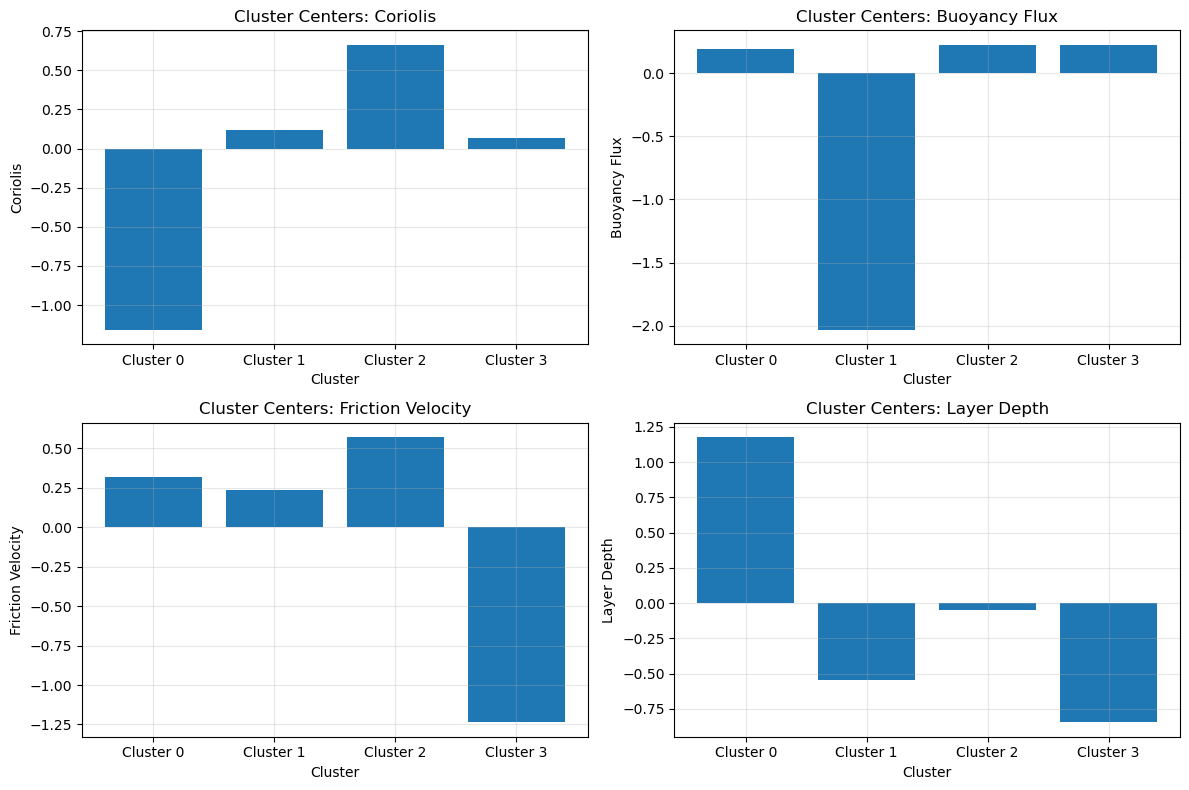

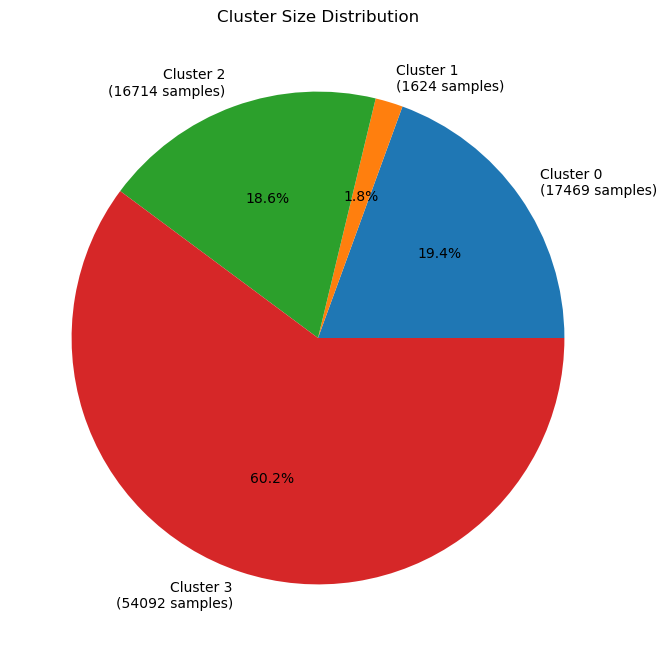

In [9]:
# Visualize the clusters
feature_names = ['Coriolis', 'Buoyancy Flux', 'Friction Velocity', 'Layer Depth']
visualizer.plot_clusters(input_clustered, valid_x_np, feature_names)

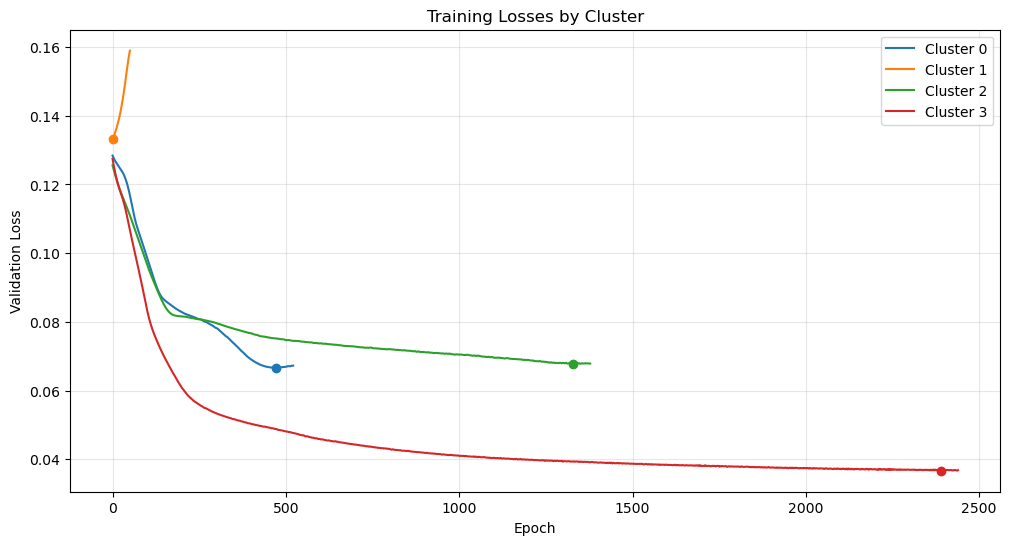

In [10]:
# Plot training losses for each cluster
visualizer.plot_losses(input_clustered)

In [11]:
# Evaluate input clustered model
input_clustered_metrics = input_clustered.evaluate(
    valid_x, valid_y, {'k_mean': k_mean, 'k_std': k_std}
)

print(f"Input Clustered overall MAE: {input_clustered_metrics['mae']:.6f}")
print("\nCluster-wise MAE:")
for cluster_id, mae in input_clustered_metrics['cluster_mae'].items():
    print(f"Cluster {cluster_id}: {mae:.6f}")

ValueError: Buffer dtype mismatch, expected 'const float' but got 'double'

In [ ]:
# Compare baseline and input clustered model performance
visualizer.plot_performance_comparison(baseline_metrics, input_clustered_metrics)

## 4. Shape Function (Output) Clustering Approach

Now we'll implement the more innovative approach of clustering based on the output shape functions.

In [ ]:
# Create the output clustered model
output_clustered = OutputClusteredModel(
    model_class=OceanMixingNN,
    model_params=model_params,
    n_clusters=4,
    random_state=42,
    use_pca=True,
    n_components=5
)

# Train the model
output_clustered.fit(
    X=x,
    y=y,
    valid_X=valid_x,
    valid_y=valid_y,
    stats={'k_mean': k_mean, 'k_std': k_std}
)

In [ ]:
# Visualize the shape function clusters
visualizer.plot_shape_functions(output_clustered, y)

In [ ]:
# Visualize feature importance for predicting shape clusters
visualizer.plot_clusters(output_clustered, x, feature_names)

In [ ]:
# Plot training losses for each shape cluster
visualizer.plot_losses(output_clustered)

In [ ]:
# Evaluate output clustered model
output_clustered_metrics = output_clustered.evaluate(
    valid_x, valid_y, {'k_mean': k_mean, 'k_std': k_std}
)

print(f"Output Clustered overall MAE: {output_clustered_metrics['mae']:.6f}")
print("\nShape Cluster-wise MAE:")
for cluster_id, mae in output_clustered_metrics['cluster_mae'].items():
    print(f"Shape Cluster {cluster_id}: {mae:.6f}")

In [ ]:
# Compare baseline and output clustered model performance
visualizer.plot_performance_comparison(baseline_metrics, output_clustered_metrics)

## 5. Comparing All Approaches

Let's compare all three approaches: baseline, input clustering, and output clustering.

In [ ]:
# Compare overall performance
plt.figure(figsize=(10, 6))
models = ['Baseline', 'Input Clustered', 'Output Clustered']
mae_values = [
    baseline_metrics['mae'],
    input_clustered_metrics['mae'],
    output_clustered_metrics['mae']
]
colors = ['blue', 'orange', 'green']

# Create bar chart
bars = plt.bar(models, mae_values, color=colors, alpha=0.7)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.6f}',
            ha='center', va='bottom')

# Calculate improvement percentages
input_improvement = (baseline_metrics['mae'] - input_clustered_metrics['mae']) / baseline_metrics['mae'] * 100
output_improvement = (baseline_metrics['mae'] - output_clustered_metrics['mae']) / baseline_metrics['mae'] * 100

# Add improvement annotations
plt.annotate(f'{input_improvement:.2f}% improvement', 
            xy=(1, input_clustered_metrics['mae']),
            xytext=(1, (baseline_metrics['mae'] + input_clustered_metrics['mae'])/2),
            arrowprops=dict(arrowstyle='->', color='orange'),
            ha='center', va='center', fontsize=12,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

plt.annotate(f'{output_improvement:.2f}% improvement', 
            xy=(2, output_clustered_metrics['mae']),
            xytext=(2, (baseline_metrics['mae'] + output_clustered_metrics['mae'])/2),
            arrowprops=dict(arrowstyle='->', color='green'),
            ha='center', va='center', fontsize=12,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

plt.ylabel('Mean Absolute Error')
plt.title('Overall Performance Comparison')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Compare node-wise performance
plt.figure(figsize=(14, 8))

x = np.arange(16)  # 16 vertical levels
width = 0.25       # width of the bars

# Create grouped bar chart
plt.bar(x - width, baseline_metrics['node_mae'], width, label='Baseline', color='blue', alpha=0.7)
plt.bar(x, input_clustered_metrics['node_mae'], width, label='Input Clustered', color='orange', alpha=0.7)
plt.bar(x + width, output_clustered_metrics['node_mae'], width, label='Output Clustered', color='green', alpha=0.7)

plt.xlabel('Vertical Level')
plt.ylabel('Mean Absolute Error')
plt.title('Node-wise Error Comparison')
plt.xticks(x, [f'L{i+1}' for i in range(16)])
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## 6. Conclusion

The class-based architecture provides a clean, flexible way to implement and compare different clustering approaches for ocean mixing parameterization. Key takeaways:

1. **Both Clustering Approaches Improve Performance**: Both input-based and output-based clustering outperform the baseline model.

2. **Shape Function Clustering**: Clustering directly on shape functions represents a more physically-motivated approach and shows promising results.

3. **Flexible Architecture**: The modular design makes it easy to experiment with different clustering algorithms, model architectures, and training parameters.

4. **Enhanced Interpretability**: Visualization tools help understand the physical meaning of clusters and their performance characteristics.

This notebook provides a foundation for further experimentation with clustered approaches to ocean mixing parameterization.